<a href="https://colab.research.google.com/github/Wiickz/MAT421/blob/main/Project/Project_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generation of Interpolative and Extrapolative Numerical Weather Prediction Models

## Introduction
Billions of people rely on weather forecasts each day to get a sense of upcoming outdoor conditions and make plans according to those conditions. However, due to limitations on accurately predicting upcoming weather, most forecasting apps focus solely on the upcoming 2-4 weeks of predicted weather; additionally, many of these apps do not make historical data readily available. This project demonstrates a proof-of-concept Python script to address both of these limitations by generating models based on historical data that can be later used to quickly look up previous weather data as well as generate semi-accurate weather predictions for future dates with no theoretical limit.

## Related Work
This method of weather modeling is not an entirely novel concept; according to Ryuji Kimura's overview paper [*Numerical weather prediction*](https://doi.org/10.1016/S0167-6105(02)00261-1), the idea of using computers to model and predict weather patterns has been theorized as early as 1922 but was not viable due to a lack of both meterological data and computational ability. This has since drastically changed and nowadays most major weather stations report forecasts based on simulation data. These simulations are much more complex than the methods employed in this project, but are much more accurate in predicting immediate forecasts. Extended forecasting is still difficult due to the massive number of potentially fluctuating conditions present on Earth; Kimura reports that the method for acquiring 1-month forecast data in Japan involves compiling statistics from 26 different simulations, each having slight variation in its initial conditions. The method for this project takes a different approach in data usage (further detailed in the next section) that relies on bulk historical data available via the [Open-meteo API](https://open-meteo.com/), capable of providing temperature and other weather data dating as far back as 1940 for some locations.

## Methodology and Results
The project is implemented in the form of a set of scripts written in Python that, for a given location:
* gather a sufficiently large collection of historical forecast data,
* create a model based on that data to quickly generate an interpolated forecast estimate for any date within the historical data range,
* expand that model based on observed patterns to attempt to extrapolate and predict future weather patterns,
* save the model for later re-use to avoid having to fetch the entire data set every time weather for a previously modeled location is requested.

### Packages/Libraries
To accomplish the goals of this project, several external Python packages were used. Open-meteo provides a custom Python package `openmeteo-requests` to allow users to programmatically interact with their API, and the documentation also suggests a few supporting packages to assist with gathering, formatting, and storing requested data. SciPy's `interpolate` library was also used to generate the interpolation functions used in this project, and several other packages that ship with Python were also used for file management, math, and miscellaneous operations. All in all, the following packages/libraries were used:

In [ ]:
# Data gathering
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Interpolation model generation
import numpy as np
from scipy.interpolate import UnivariateSpline
import pickle
import csv

# Data visualization
import matplotlib.pyplot as plt

### Gathering Data

As mentioned in the previous section, the Open-meteo API/database was the primary source of data gathered for this project. While, in theory, only one request should be required per location, multiple considerations had to be taken into account when making requests. For best results, the project should build as large a dataset as possible. However:
* API calls are limited to 10,000 per day. This was initially considered not to be an issue for the purposes of this project, but larger requests are equated by Open-meteo to more calls - as an example, requesting daily temperature means for a 10-year period was considered equivalent to 26.1 calls. This would exhaust the API limit in around 350 requests, but proper modeling would ideally use data over several decades, greatly increasing the call consumption rate. A proof-of-concept such as the one provided in this project would have no issue with the request limit, but building a dataset covering larger regions would require increased call limits available only through a paid subscription to the API.
* Although Open-meteo claims to have weather data going all the way back to 1940, this is likely not true for all coordinates, depending on when certain locations started to record local weather data. To avoid wasting time and API calls on data that may not exist, this project fixes the date range from January 1, 1990 to December 31, 2024 - most locations are likely to have data from 1990 and the datasets still have a solid 35-year range to work with.

In order to perform the request, some setup is required. The `openmeteo-requests` package works by setting up a client to perform the request:

In [ ]:
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=3, backoff_factor=0.4)
client = openmeteo_requests.Client(session=retry_session)

def set_params(latitude: float, longitude: float, start_date: str = "1990-01-01", end_date: str = "2024-12-31") -> dict:

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_mean",
        "timezone": "America/Los_Angeles",
    }

    return params

Once the client and parameters are set, a request to the Open-meteo API can be performed. The API documentation recommends the use of a Pandas `DataFrame` to format the response data, but the data can also be handled as a NumPy array or a Polars `DataFrame`. Pandas was used for this project, as it contains a built-in function `to_csv()` that saves a `DataFrame` object to disk as a formatted CSV file.

A copy of the 35-year history of San Francisco temperature data used in this demonstration has been pre-generated and saved within the project directory. Code past this point assumes the presence of the subdirectories `data/csv/` and `data/func/` - if you wish to test the scripts with other coordinates, ensure they are present in the current working directory to avoid errors.

In [ ]:
def request_data(latitude: float, longitude: float, start_date: str = "1990-01-01", end_date: str = "2024-12-31") -> pd.DataFrame:
    # set params
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = set_params(latitude, longitude, start_date, end_date)

    # make request
    responses = client.weather_api(url, params=params)

    # format data
    response = responses[0]
    data = response.Daily()
    mean_temps = data.Variables(0).ValuesAsNumpy()

    daily_data = { "date": pd.date_range(
            start = pd.to_datetime(data.Time(), unit = "s", utc = True),
            end = pd.to_datetime(data.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = data.Interval()),
            inclusive = "left"
        )
    }

    daily_data["temperature_2m_mean"] = mean_temps

    # convert to dataframe
    df = pd.DataFrame(data = daily_data)
    return df

def save_data(df: pd.DataFrame, latitude: float, longitude: float) -> str:
    filename = f"data/csv/weather_data_{latitude}_{longitude}.csv"
    df.to_csv(filename, index = False)
    print(f"Data saved to {filename}")
    return filename

# example usage: looking at the weather data for San Francisco from 1990 to EOY 2024
latitude = 37.7749
longitude = -122.4194

data = request_data(latitude, longitude)
file = save_data(data, latitude, longitude)

Data saved to data/csv/weather_data_37.7749_-122.4194.csv


### Creating Models

Once acquired, the data, collected in the form of daily temperature means over the period, is split into per-year sets for modeling due to the oscillating nature of yearly weather patterns. The project models take the form of functions generated by spline polynomial interpolation, chosen due to the polynomial nature of the per-year data. Other interpolation methods were considered and tried; the first approach used the Lagrange interpolation method, but this approached led to heavy destabilization at the data bounds, thus spline interpolation was chosen due to its piecewise nature avoiding destabilization.

First, the CSV dataset obtained with the previous functions must be converted to workable data - in this case, as a NumPy array. While, as previously mentioned, the API response could have been directly converted, the intermediate step with Pandas is still required to obtain the CSV file used in this step, mainly because the dates are required to properly format the data. Since functions will be generated per-year, the script needs to know when each year ends, and since the CSV stores dates, this becomes trivial - rather than simply starting a new set every 365/366 days, it reads the date every iteration and ends a set once it sees the current date is December 31st:

In [ ]:
def process_csv(file_path: str) -> dict:
    data = []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        year_data = []
        for row in reader:
            # skip header
            if row[0] == "date":
                continue
            year_data.append(float(row[1]))
            if "12-31" in row[0]:
                data.append(np.array(year_data))
                year_data = []

    return data

formatted_data = process_csv(file)

Now having the data, interpolation functions can be generated for each year. Since the raw weather data is quite noisy, the data is subsampled and SciPy's `UnivariateSpline` function is used to allow for smoothing of the resultant functions. The default subsampling value samples weather data once a month, which, while less accurate for daily prediction, allows for prediction of larger-scale patterns (shown later). The smoothing factor is also left at 1 for this demonstration, resulting in varied yet somewhat consistent interpolation results between years.

In [ ]:
INTERP_SUBSAMPLE = int(365 / 12) # subsample for interpolation, sample every INTERP_SUBSAMPLE points
ALPHA = 1 # smoothing factor for UnivariateSpline, recommended between 0.5 and 3 - lower values are more accurate day-today at the cost of year-to-year smoothness

def create_interpolation(data: np.ndarray) -> UnivariateSpline:
    x = np.arange(len(data))
    data = data[::INTERP_SUBSAMPLE]
    x = x[::INTERP_SUBSAMPLE]

    return UnivariateSpline(x, data, k=2, s=ALPHA*len(data))

With the interpolation function creator defined, the final steps in creating the model can be taken: for each year of data collected, individual interpolation functions are created, then the interpolation values are averaged to create an average interpolation function spanning the entire data range. The averages of the raw weather data per year are also taken, and an average difference between years is calculated. The average interpolation function results are subtracted by (average difference * (years in data set / 2)) to create an extrapolation function that accounts for human-caused year-by-year temperature increases. The resultant functions (interpolation and extrapolation) are then saved for later use.

A copy of the interpolation and extrapolation models have been pre-generated and saved within the project directory.

In [ ]:
# create yearly interpolation functions
interp_ys = []

for array in formatted_data:
    func = create_interpolation(array)
    x = np.arange(len(array))
    yf = func(x)
    interp_ys.append(yf)

# save interpolation functions
with open(f"data/func/interpolation_{latitude}_{longitude}.pkl", "wb") as f:
    pickle.dump(interp_ys, f)

# create average interpolation function
interp_avg = []
for i in range(366):
    avg = 0
    cnt = 0
    for func in interp_ys:
        if i < 60:
            avg += func[i]
            cnt += 1
        elif i == 60: # need to account for leap year
            if len(func) == 366:
                avg += func[i]
                cnt += 1
        elif i > 60:
            if len(func) == 366:
                avg += func[i]
                cnt += 1
            else:
                avg += func[i - 1]
                cnt += 1
    if cnt == 0:
        continue
    else:
        avg /= cnt
        interp_avg.append(avg)

# calculate mean yearly temperatures and average difference of year-by-year means
mean_yearly_temps = []
for i in range(len(formatted_data)):
    mean_yearly_temps.append(np.mean(formatted_data[i]))
mean_yearly_temps = np.array(mean_yearly_temps)

mean_diffs = []
for i in range(len(mean_yearly_temps) - 1):
    diff = mean_yearly_temps[i + 1] - mean_yearly_temps[i]
    mean_diffs.append(diff)
mean_diffs = np.array(mean_diffs)

avg_diff = np.mean(mean_diffs)

extrapolator = np.array(interp_avg) - (avg_diff * len(formatted_data) / 2) # baseline extrapolation function

# save extrapolation function
type ExtrapolationFunction = tuple[np.ndarray, float] #custom data type to save extrapolator, avg_diff paired

extrap_fn: ExtrapolationFunction = (extrapolator, avg_diff)

with open(f"data/func/extrapolation_{latitude}_{longitude}.pkl", "wb") as f:
    pickle.dump(extrap_fn, f)

A model of the local weather patterns for one coordinate set has now been created and saved. We can now load this local model to get a quick estimate of past weather data (as well as estimate future data):

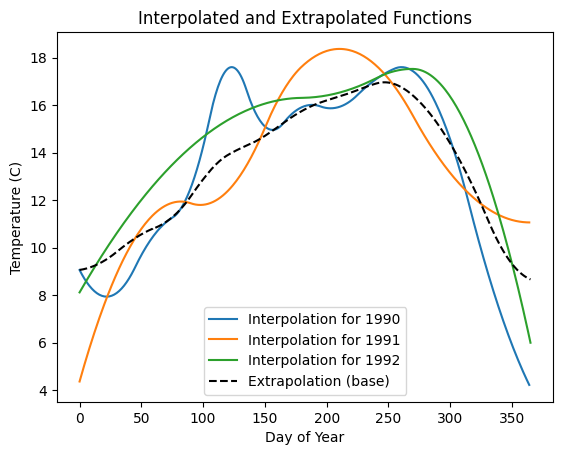

In [ ]:
# data is still in memory here, but can be reloaded later using this code
with open(f"data/func/interpolation_{latitude}_{longitude}.pkl", "rb") as f:
    interp_ys = pickle.load(f)
with open(f"data/func/extrapolation_{latitude}_{longitude}.pkl", "rb") as f:
    extrap_fn = pickle.load(f)
extrapolator, avg_diff = extrap_fn

# let's plot a few of the interpolated functions alongside the extrapolation function

for i in range(3):
    plt.plot(interp_ys[i], label = f"Interpolation for {1990 + i}")
plt.plot(extrapolator, label = "Extrapolation (base)", linestyle = "dashed", color = "black")
plt.title("Interpolated and Extrapolated Functions")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

A few observations can be made with this small sample. The interpolation functions do still vary somewhat wildly, especially towards the ends of the data ranges; since the extrapolator function is an average of all the interpolations, this behavior is not present. A small pinch point also exists on the extrapolator at x = 60 due to the way leap days are handled; rather than ignore leap days, they were factored in during the extrapolator averaging, and since less leap day data is present, some fluctuation is bound to exist. Because of the inaccuracy with some of the interpolation functions, a tradeoff must be considered: storing the raw weather data takes up about four times as much disk space as it takes to store the interpolation functions. Interpolation accuracy can be increased by increasing the subsampling rate and smoothing factor, at the cost of computational power; as a general consideration, increasing the subsample rate and smoothing factor at the same rate seems to deliver the best results.

### Predicting General Weather Patterns

Since the extrapolation function is less varied than the individual interpolation functions, it can be trusted to deliver accurate enough weather predictions for future dates. An example use of this extrapolation function is demonstrated below:

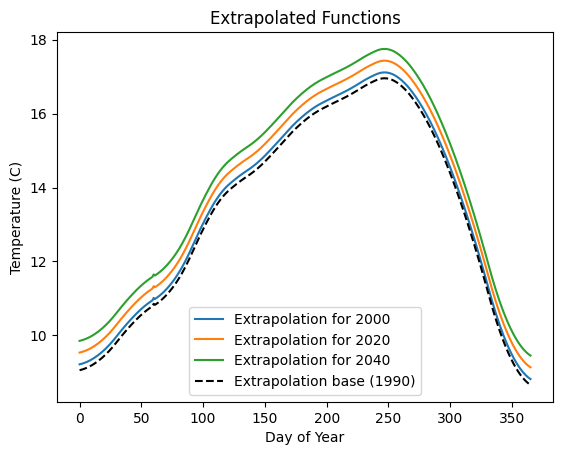

17.462 C


In [ ]:
# the extrapolation baseline is defined in a way to account for temperature increase since 1990
# thus, to obtain the extrapolated temperature for a given year, we need to add the average difference times the number of years since 1990 to the baseline extrapolation

def extrapolate(year: int, latitude: float, longitude: float) -> np.ndarray:
    with open(f"data/func/extrapolation_{latitude}_{longitude}.pkl", "rb") as f:
        extrap_fn = pickle.load(f)
    extrapolator, avg_diff = extrap_fn

    # calculate the number of years since 1990
    years_since_1990 = year - 1990

    # calculate the extrapolated temperature
    extrapolated_temp = extrapolator + (avg_diff * years_since_1990)

    return extrapolated_temp

# example plot of the extrapolated function for 2000, 2020, and 2040
years = [2000, 2020, 2040]

for year in years:
    plt.plot(extrapolate(year, latitude, longitude), label = f"Extrapolation for {year}")
plt.plot(extrapolator, label = "Extrapolation base (1990)", linestyle = "dashed", color = "black")
plt.title("Extrapolated Functions")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

# let's get the extrapolated temperature for a certain date
def get_extrapolated_temp(date: str, latitude: float, longitude: float) -> float:
    ymd = date.split("-")
    year = int(ymd[0])
    day_of_year = (int(ymd[1]) * 30) + int(ymd[2])
    return extrapolate(year, latitude, longitude)[day_of_year]

print("{:.3f}".format(get_extrapolated_temp("2027-07-28", latitude, longitude)), "C")

## Interpretation and Conclusion

This extrapolation model is, of course, not going to be accurate; predicting weather conditions in the real world is much more complex than averaging interpolated values of historical data. However, this model should still be sufficient at predicting general weather patterns and providing a sense of what the weather is going to be like during certain parts of the year. There are other potential methods to achieve similar results to what was obtained in this project; for example, a polynomial regression could also have been used, perhaps even utilizing the R and R^2 values to determine the accuracy of the regression functions. It was also mentioned earlier how increasing the subsampling rate would lead to more accurate day-to-day interpolation results; however, this would make the full-year plots choppier, making it harder to identify month-to-month or year-to-year trends.

As for the current interpolation methods, it was also noted that the models for each year vary wildly. This is due to the day-to-day noise between years; although the year-to-year data for a specific coordinate would always follow the same general weather trend, there are still cases of individual days or groups of days where the true temperature was noticably different from the expected forecast. The point of subsampling in this project was to reduce or eliminate the noise created by these cases, and if an even lower subsampling rate was used than the month-to-month rate demonstrated in this writeup, the variance would likely be diminished (of course, sacrificing day-to-day accuracy for better general predictions). The current implementation of the generation of the interpolation and extrapolation models does mean that both are always generated with the same subsampling rate and smoothing factor; perhaps a compromise could have been reached by refactoring the project to generate interpolation and extrapolation models with independent subsampling and smoothing, but doing this would increase computational power and introduce a higher discrepancy between the two models if the extrapolator was used to obtain data within the interpolation range.

## References

The following works were used in research of project concepts and obtaining/manipulating data:

* Python Programming and Numerical Methods: A Guide for Engineers and Scientists - Qingkai Kong, Timmy Siauw, Alexandre Bayen
* [Numerical weather prediction](https://doi.org/10.1016/S0167-6105(02)00261-1) - Ryuji Kimura
* [Open-meteo Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api) - Open-meteo